In [44]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution
import os

# Reload the models module
import importlib
import models
importlib.reload(models)

from models import Model

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Imports successful!")

Imports successful!


## Load Temperature-Dependent Data

Load data from the Temps-data folder for Cells A, B, and C at 30°C, 40°C, and 50°C.

In [45]:
# Define data class
class TafelData:
    def __init__(self, eta, lnk):
        self.eta = np.array(eta)
        self.lnk = np.array(lnk)

# Load all temperature data
base_path = 'Temps-data'
cells = ['Cell A', 'Cell B', 'Cell C']
temperatures = [30, 40, 50]  # °C

# Dictionary to store all data: {temp: {cell: TafelData}}
temp_data = {}

for temp in temperatures:
    temp_data[temp] = {}
    for cell in cells:
        cell_letter = cell.split()[-1]  # 'A', 'B', or 'C'
        filename = f"{temp}_{cell_letter}.csv"
        filepath = os.path.join(base_path, cell, filename)
        
        try:
            df = pd.read_csv(filepath)
            # Clean column names
            df.columns = [col.strip() for col in df.columns]
            eta = df['x'].values  # overpotential
            lnk = df['y'].values  # ln(k)
            temp_data[temp][cell] = TafelData(eta, lnk)
            print(f"Loaded {cell} at {temp}°C: {len(eta)} points")
        except Exception as e:
            print(f"Error loading {filepath}: {e}")

print(f"\nTotal datasets loaded: {sum(len(d) for d in temp_data.values())}")

Loaded Cell A at 30°C: 20 points
Loaded Cell B at 30°C: 20 points
Loaded Cell C at 30°C: 21 points
Loaded Cell A at 40°C: 19 points
Loaded Cell B at 40°C: 18 points
Loaded Cell C at 40°C: 19 points
Loaded Cell A at 50°C: 19 points
Loaded Cell B at 50°C: 20 points
Loaded Cell C at 50°C: 19 points

Total datasets loaded: 9


In [46]:
# Create averaged datasets for each temperature
def average_cell_data(cell_dict):
    """Average data from multiple cells at the same temperature."""
    all_eta = []
    all_lnk = []
    
    for cell_name, data in cell_dict.items():
        all_eta.extend(data.eta)
        all_lnk.extend(data.lnk)
    
    # Sort by eta and return
    sorted_indices = np.argsort(all_eta)
    return TafelData(np.array(all_eta)[sorted_indices], 
                     np.array(all_lnk)[sorted_indices])

# Create averaged data for each temperature
avg_temp_data = {}
for temp in temperatures:
    avg_temp_data[temp] = average_cell_data(temp_data[temp])
    print(f"{temp}°C averaged data: {len(avg_temp_data[temp].eta)} points")
    print(f"  η range: {avg_temp_data[temp].eta.min():.2f} to {avg_temp_data[temp].eta.max():.2f} V")
    print(f"  ln(k) range: {avg_temp_data[temp].lnk.min():.2f} to {avg_temp_data[temp].lnk.max():.2f}")
    print()

30°C averaged data: 61 points
  η range: -15.13 to 15.74 V
  ln(k) range: -9.35 to -5.00

40°C averaged data: 56 points
  η range: -15.65 to 14.11 V
  ln(k) range: -7.99 to -5.08

50°C averaged data: 58 points
  η range: -15.18 to 13.41 V
  ln(k) range: -8.96 to -5.02



## Visualize Temperature-Dependent Data

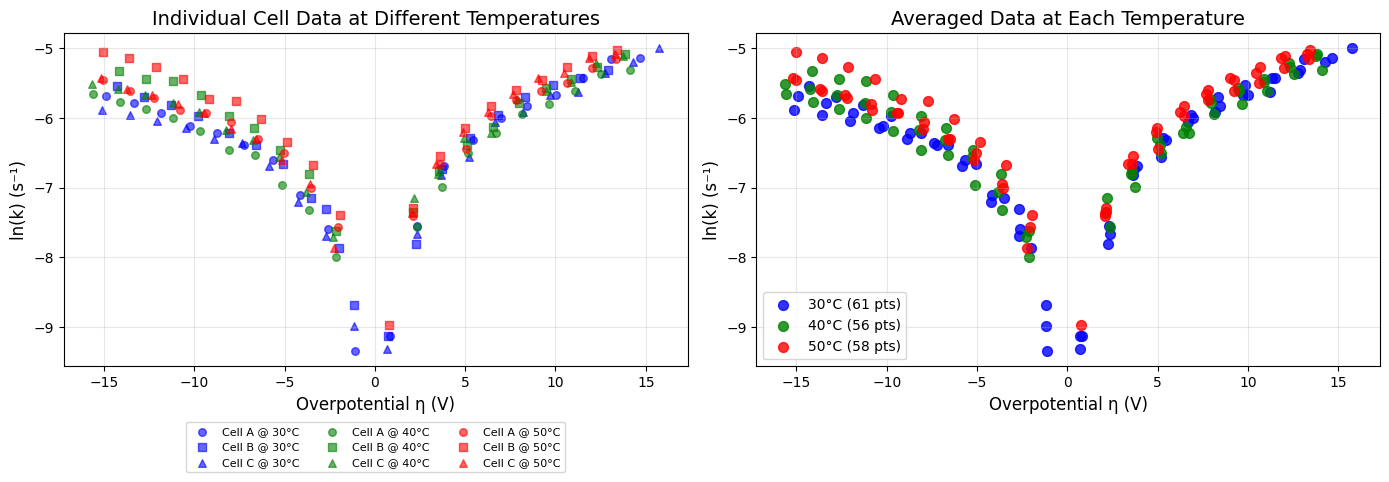

In [47]:
# Plot all temperature data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {30: 'blue', 40: 'green', 50: 'red'}
markers = {'Cell A': 'o', 'Cell B': 's', 'Cell C': '^'}

# Plot 1: Individual cells at each temperature
ax1 = axes[0]
for temp in temperatures:
    for cell in cells:
        if cell in temp_data[temp]:
            data = temp_data[temp][cell]
            ax1.scatter(data.eta, data.lnk, 
                       color=colors[temp], marker=markers[cell],
                       alpha=0.6, s=30, 
                       label=f'{cell} @ {temp}°C')

ax1.set_xlabel('Overpotential η (V)', fontsize=12)
ax1.set_ylabel('ln(k) (s⁻¹)', fontsize=12)
ax1.set_title('Individual Cell Data at Different Temperatures', fontsize=14)
ax1.legend(fontsize=8, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax1.grid(True, alpha=0.3)

# Plot 2: Averaged data at each temperature
ax2 = axes[1]
for temp in temperatures:
    data = avg_temp_data[temp]
    ax2.scatter(data.eta, data.lnk, 
               color=colors[temp], s=50, alpha=0.8,
               label=f'{temp}°C ({len(data.eta)} pts)')

ax2.set_xlabel('Overpotential η (V)', fontsize=12)
ax2.set_ylabel('ln(k) (s⁻¹)', fontsize=12)
ax2.set_title('Averaged Data at Each Temperature', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Define Fixed λ Fitting Functions

Set up the optimization with λ fixed at 8.3, optimizing only k01 and C.

In [48]:
# Fixed parameters
LAMBDA_FIXED = 8.3
K02_FIXED = 2.093e-4  # s⁻¹
MASK_THRESHOLD = -8.0

def residual_function_fixed_lambda(params, data, lambda_fixed=LAMBDA_FIXED, 
                                    k02_fixed=K02_FIXED, mask_threshold=MASK_THRESHOLD):
    """
    Residual function with lambda fixed.
    params: [k01, C]
    """
    k01, C = params
    
    try:
        model = Model(model='MHC2', k01=k01, k02=k02_fixed, lambda_=lambda_fixed, 
                     eta=data.eta, C=C, origin_eta=True)
        
        eta_model, lnk_model = model.ln_k()
        lnk_pred = np.interp(data.eta, eta_model, lnk_model)
        
        mask = data.lnk >= mask_threshold
        residuals = (data.lnk[mask] - lnk_pred[mask])
        
        if len(residuals) == 0:
            return np.array([1e6])
            
        return residuals
        
    except Exception as e:
        return np.array([1e6])

def objective_function_fixed_lambda(params, data):
    """Objective function for fixed lambda optimization."""
    residuals = residual_function_fixed_lambda(params, data)
    return np.sum(residuals**2)

print(f"Fixed parameters:")
print(f"  λ = {LAMBDA_FIXED}")
print(f"  k02 = {K02_FIXED:.4e} s⁻¹")
print(f"  Mask threshold = {MASK_THRESHOLD}")
print(f"\nParameters to optimize: k01, C")

Fixed parameters:
  λ = 8.3
  k02 = 2.0930e-04 s⁻¹
  Mask threshold = -8.0

Parameters to optimize: k01, C


## Fit MHC Model at Each Temperature

Run optimization for each temperature with λ fixed at 8.3.

In [49]:
# Bounds for k01 and C
bounds = [(1e-6, 1e-2), (0.1, 2.0)]  # [k01, C]

# Store results - keyed by (cell_letter, temperature)
fit_results = {}

cell_names = ['Cell A', 'Cell B', 'Cell C']

print("=" * 80)
print("FITTING MHC MODEL WITH FIXED λ = 8.3 FOR EACH CELL AND TEMPERATURE")
print("=" * 80)

for cell_name in cell_names:
    cell_letter = cell_name.split()[-1]  # 'A', 'B', or 'C'
    print(f"\n{'#'*80}")
    print(f"# CELL {cell_letter}")
    print(f"{'#'*80}")
    
    for temp in temperatures:
        print(f"\n{'='*60}")
        print(f"Cell {cell_letter} - Temperature: {temp}°C ({temp + 273.15} K)")
        print(f"{'='*60}")
        
        data = temp_data[temp][cell_name]
        
        # Run differential evolution
        def obj_func(params):
            return objective_function_fixed_lambda(params, data)
        
        result = differential_evolution(
            obj_func,
            bounds,
            maxiter=500,
            popsize=20,
            seed=42,
            disp=True,
            polish=True
        )
        
        k01_opt, C_opt = result.x
        sse = result.fun
        
        # Calculate R²
        model = Model(model='MHC2', k01=k01_opt, k02=K02_FIXED, lambda_=LAMBDA_FIXED, 
                     eta=data.eta, C=C_opt, origin_eta=True)
        eta_model, lnk_model = model.ln_k()
        lnk_pred = np.interp(data.eta, eta_model, lnk_model)
        
        mask = data.lnk >= MASK_THRESHOLD
        ss_res = np.sum((data.lnk[mask] - lnk_pred[mask])**2)
        ss_tot = np.sum((data.lnk[mask] - np.mean(data.lnk[mask]))**2)
        r2 = 1 - (ss_res / ss_tot)
        rmse = np.sqrt(np.mean((data.lnk[mask] - lnk_pred[mask])**2))
        
        print(f"\nResults for Cell {cell_letter} at {temp}°C:")
        print(f"  k01 = {k01_opt:.6e} s⁻¹")
        print(f"  C = {C_opt:.4f}")
        print(f"  λ = {LAMBDA_FIXED} (FIXED)")
        print(f"  SSE = {sse:.6f}")
        print(f"  R² = {r2:.4f}")
        print(f"  RMSE = {rmse:.4f}")
        
        # Store results
        fit_results[(cell_letter, temp)] = {
            'cell': cell_letter,
            'k01': k01_opt,
            'C': C_opt,
            'lambda': LAMBDA_FIXED,
            'sse': sse,
            'r2': r2,
            'rmse': rmse,
            'model': model,
            'T_kelvin': temp + 273.15,
            'temperature': temp
        }

print("\n" + "=" * 80)
print("FITTING COMPLETE - All 9 individual cell/temperature combinations fitted")
print("=" * 80)

FITTING MHC MODEL WITH FIXED λ = 8.3 FOR EACH CELL AND TEMPERATURE

################################################################################
# CELL A
################################################################################

Cell A - Temperature: 30°C (303.15 K)
differential_evolution step 1: f(x)= 4.034879656522924
differential_evolution step 2: f(x)= 4.034879656522924
differential_evolution step 3: f(x)= 1.928992471108017
differential_evolution step 4: f(x)= 1.928992471108017
differential_evolution step 5: f(x)= 0.4449203509960448
differential_evolution step 6: f(x)= 0.4449203509960448
differential_evolution step 7: f(x)= 0.4449203509960448
differential_evolution step 8: f(x)= 0.4449203509960448
differential_evolution step 9: f(x)= 0.4376945626270268
differential_evolution step 10: f(x)= 0.4376945626270268
differential_evolution step 11: f(x)= 0.4376945626270268
differential_evolution step 12: f(x)= 0.4339505125794018
differential_evolution step 13: f(x)= 0.43395051257

## Results Summary Table

In [50]:
# Create summary table for individual cells
print("=" * 100)
print("INDIVIDUAL CELL PARAMETER SUMMARY (λ = 8.3 FIXED)")
print("=" * 100)

print("\n{:<10} {:>10} {:>10} {:>15} {:>12} {:>12} {:>12}".format(
    "Cell", "Temp (°C)", "T (K)", "k01 (s⁻¹)", "C", "R²", "RMSE"))
print("-" * 100)

cell_letters = ['A', 'B', 'C']
for cell in cell_letters:
    for temp in temperatures:
        key = (cell, temp)
        if key in fit_results:
            r = fit_results[key]
            print(f"{cell:<10} {temp:>10} {r['T_kelvin']:>10.2f} {r['k01']:>15.4e} {r['C']:>12.4f} {r['r2']:>12.4f} {r['rmse']:>12.4f}")
    print("-" * 100)

# Create DataFrame for export
results_list = []
for cell in cell_letters:
    for temp in temperatures:
        key = (cell, temp)
        if key in fit_results:
            r = fit_results[key]
            results_list.append({
                'Cell': cell,
                'Temperature_C': temp,
                'Temperature_K': r['T_kelvin'],
                'k01': r['k01'],
                'C': r['C'],
                'lambda': LAMBDA_FIXED,
                'SSE': r['sse'],
                'R2': r['r2'],
                'RMSE': r['rmse']
            })

results_df = pd.DataFrame(results_list)

print("\nDataFrame:")
display(results_df)

# Calculate average values per temperature for comparison
print("\n" + "=" * 80)
print("AVERAGE VALUES PER TEMPERATURE")
print("=" * 80)
avg_by_temp = results_df.groupby('Temperature_C').agg({
    'k01': ['mean', 'std'],
    'C': ['mean', 'std'],
    'R2': 'mean'
}).round(6)
print(avg_by_temp)

INDIVIDUAL CELL PARAMETER SUMMARY (λ = 8.3 FIXED)

Cell        Temp (°C)      T (K)       k01 (s⁻¹)            C           R²         RMSE
----------------------------------------------------------------------------------------------------
A                  30     303.15      2.1102e-04       0.5042       0.9508       0.1552
A                  40     313.15      1.8106e-04       0.5567       0.9670       0.1331
A                  50     323.15      2.2962e-04       0.5911       0.9221       0.1868
----------------------------------------------------------------------------------------------------
B                  30     303.15      2.1708e-04       0.5730       0.9606       0.1542
B                  40     313.15      2.0931e-04       0.8003       0.9630       0.1371
B                  50     323.15      2.5505e-04       0.7936       0.9528       0.1532
----------------------------------------------------------------------------------------------------
C                  30     303.

,Cell,Temperature_C,Temperature_K,k01,C,lambda,SSE,R2,RMSE
0,A,30,303.15,0.000211,0.504248,8.3,0.433445,0.950835,0.155178
1,A,40,313.15,0.000181,0.556735,8.3,0.336441,0.966987,0.133069
2,A,50,323.15,0.000230,0.591052,8.3,0.662975,0.922054,0.186798
3,B,30,303.15,0.000217,0.572965,8.3,0.427796,0.960623,0.154164
4,B,40,313.15,0.000209,0.800280,8.3,0.338151,0.963037,0.137063
5,B,50,323.15,0.000255,0.793602,8.3,0.445653,0.952781,0.153152
6,C,30,303.15,0.000200,0.466181,8.3,0.457149,0.955262,0.155114
7,C,40,313.15,0.000228,0.558593,8.3,0.708019,0.920298,0.193039
8,C,50,323.15,0.000271,0.473658,8.3,0.563128,0.944888,0.172158



AVERAGE VALUES PER TEMPERATURE
                    k01                   C                  R2
                   mean       std      mean       std      mean
Temperature_C                                                  
30             0.000209  0.000009  0.514465  0.054120  0.955573
40             0.000206  0.000023  0.638536  0.140077  0.950107
50             0.000252  0.000021  0.619438  0.161850  0.939908


## Visualize Model Fits at Each Temperature

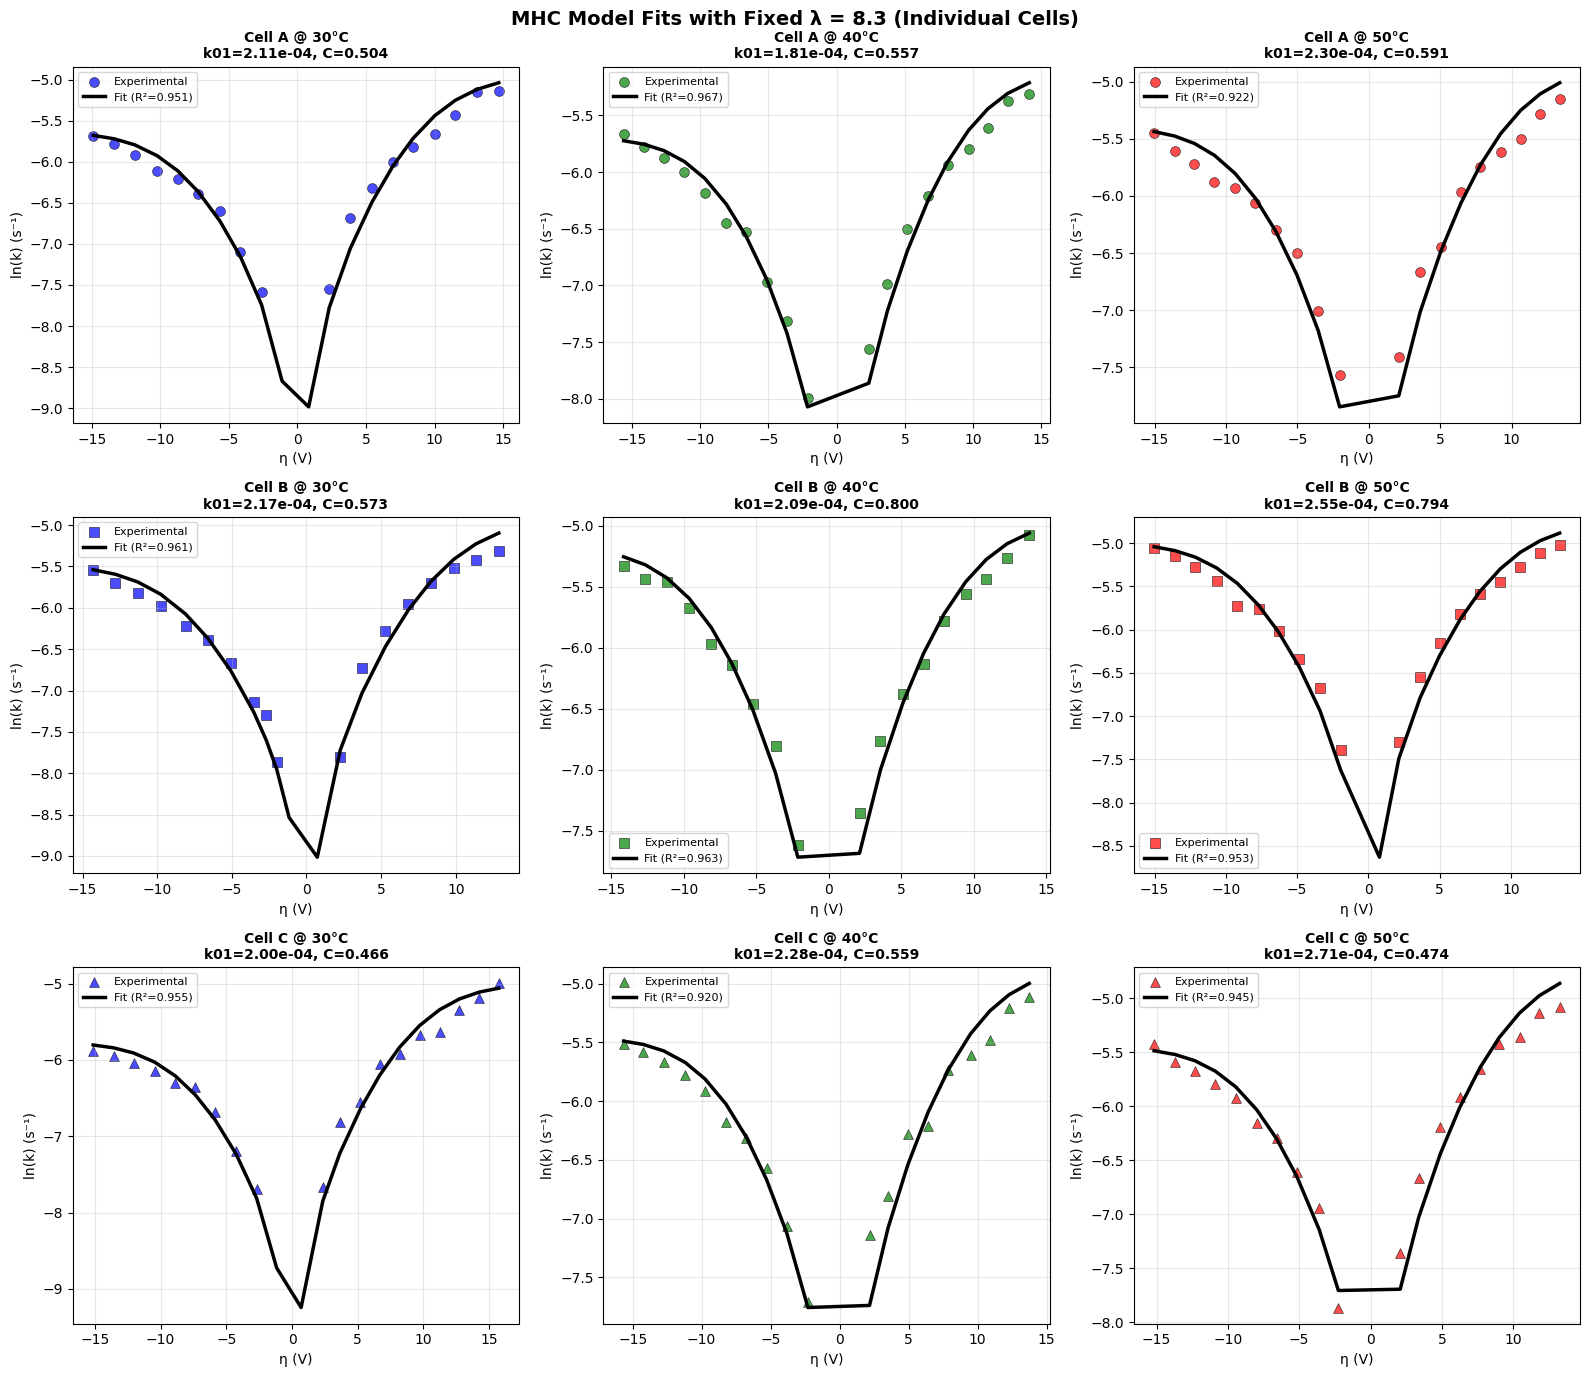

In [51]:
# Plot fits for each cell at each temperature (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(16, 14))

temp_colors = {30: 'blue', 40: 'green', 50: 'red'}
cell_markers = {'A': 'o', 'B': 's', 'C': '^'}

cell_letters = ['A', 'B', 'C']
cell_names = ['Cell A', 'Cell B', 'Cell C']

for row_idx, cell in enumerate(cell_letters):
    cell_name = cell_names[row_idx]
    for col_idx, temp in enumerate(temperatures):
        ax = axes[row_idx, col_idx]
        key = (cell, temp)
        
        if key in fit_results:
            data = temp_data[temp][cell_name]
            result = fit_results[key]
            
            # Plot experimental data
            mask = data.lnk >= MASK_THRESHOLD
            ax.scatter(data.eta[mask], data.lnk[mask], 
                      color=temp_colors[temp], s=50, alpha=0.7,
                      marker=cell_markers[cell],
                      label='Experimental', edgecolors='black', linewidth=0.5)
            
            # Plot model fit
            eta_model, lnk_model = result['model'].ln_k()
            ax.plot(eta_model, lnk_model, 'k-', linewidth=2.5,
                   label=f'Fit (R²={result["r2"]:.3f})')
            
            ax.set_title(f'Cell {cell} @ {temp}°C\nk01={result["k01"]:.2e}, C={result["C"]:.3f}', 
                        fontsize=10, fontweight='bold')
        else:
            ax.set_title(f'Cell {cell} @ {temp}°C\nNo data', fontsize=10)
        
        ax.set_xlabel('η (V)', fontsize=10)
        ax.set_ylabel('ln(k) (s⁻¹)', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle(f'MHC Model Fits with Fixed λ = {LAMBDA_FIXED} (Individual Cells)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('temperature_fits_individual_cells.png', dpi=150, bbox_inches='tight')
plt.show()

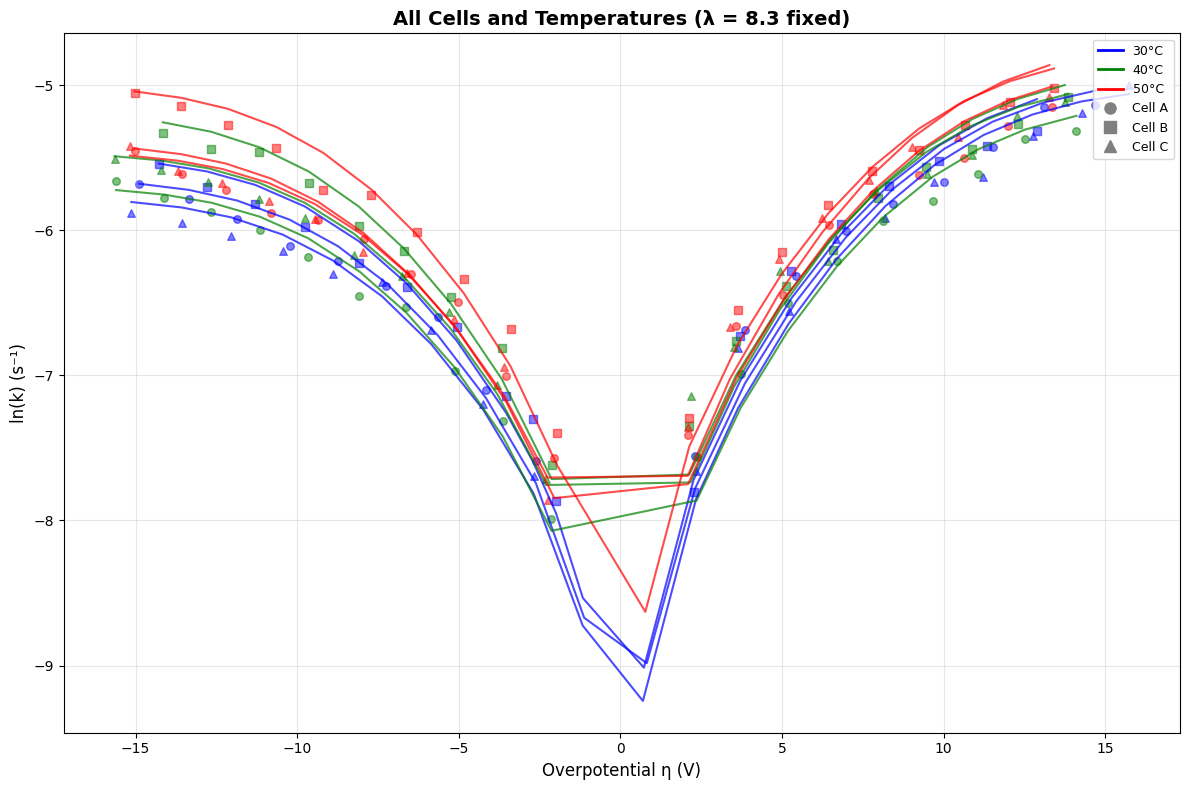

In [52]:
# Overlay all cells grouped by temperature
fig, ax = plt.subplots(figsize=(12, 8))

temp_colors = {30: 'blue', 40: 'green', 50: 'red'}
cell_markers = {'A': 'o', 'B': 's', 'C': '^'}

cell_letters = ['A', 'B', 'C']
cell_names = ['Cell A', 'Cell B', 'Cell C']

for temp in temperatures:
    for cell, cell_name in zip(cell_letters, cell_names):
        key = (cell, temp)
        if key in fit_results:
            data = temp_data[temp][cell_name]
            result = fit_results[key]
            
            # Plot experimental data
            mask = data.lnk >= MASK_THRESHOLD
            ax.scatter(data.eta[mask], data.lnk[mask], 
                      color=temp_colors[temp], s=30, alpha=0.5,
                      marker=cell_markers[cell])
            
            # Plot model fit
            eta_model, lnk_model = result['model'].ln_k()
            ax.plot(eta_model, lnk_model, color=temp_colors[temp], linewidth=1.5,
                   linestyle='-', alpha=0.7)

# Create legend handles
from matplotlib.lines import Line2D
temp_handles = [Line2D([0], [0], color=c, linewidth=2, label=f'{t}°C') 
                for t, c in temp_colors.items()]
cell_handles = [Line2D([0], [0], marker=m, color='gray', linestyle='', markersize=8, label=f'Cell {c}') 
                for c, m in cell_markers.items()]

ax.set_xlabel('Overpotential η (V)', fontsize=12)
ax.set_ylabel('ln(k) (s⁻¹)', fontsize=12)
ax.set_title(f'All Cells and Temperatures (λ = {LAMBDA_FIXED} fixed)', fontsize=14, fontweight='bold')
ax.legend(handles=temp_handles + cell_handles, fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temperature_overlay_individual_cells.png', dpi=150, bbox_inches='tight')
plt.show()

## Analyze Temperature Dependence of k01

According to transition state theory, the rate constant follows an Arrhenius relationship:

$$k = A \exp\left(-\frac{E_a}{RT}\right)$$

or in logarithmic form:

$$\ln(k) = \ln(A) - \frac{E_a}{R} \cdot \frac{1}{T}$$

We can extract the activation energy from the slope of ln(k01) vs 1/T.

In [53]:
# Arrhenius analysis of k01 for each cell
R = 8.314  # J/(mol·K)

from scipy.stats import linregress

print("Arrhenius Analysis of k01 (Individual Cells)")
print("=" * 70)

arrhenius_results = {}
cell_letters = ['A', 'B', 'C']

for cell in cell_letters:
    # Extract data for this cell across temperatures
    cell_data = [(temp, fit_results[(cell, temp)]) for temp in temperatures if (cell, temp) in fit_results]
    
    if len(cell_data) >= 2:
        T_kelvin = np.array([d[1]['T_kelvin'] for d in cell_data])
        k01_values = np.array([d[1]['k01'] for d in cell_data])
        C_values = np.array([d[1]['C'] for d in cell_data])
        
        # Calculate 1/T and ln(k01)
        inv_T = 1 / T_kelvin
        ln_k01 = np.log(k01_values)
        
        # Linear regression for Arrhenius plot
        slope, intercept, r_value, p_value, std_err = linregress(inv_T, ln_k01)
        
        # Calculate activation energy
        Ea = -slope * R  # J/mol
        Ea_kJ = Ea / 1000  # kJ/mol
        A = np.exp(intercept)  # Pre-exponential factor
        
        arrhenius_results[cell] = {
            'T_kelvin': T_kelvin,
            'k01_values': k01_values,
            'C_values': C_values,
            'inv_T': inv_T,
            'ln_k01': ln_k01,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'Ea_kJ': Ea_kJ,
            'A': A
        }
        
        print(f"\nCell {cell}:")
        print(f"  Ea = {Ea_kJ:.2f} kJ/mol")
        print(f"  A = {A:.4e} s⁻¹")
        print(f"  R² = {r_value**2:.4f}")

# Also calculate for all data combined
print("\n" + "-" * 70)
print("Combined (all cells):")
all_inv_T = []
all_ln_k01 = []
for cell in cell_letters:
    for temp in temperatures:
        key = (cell, temp)
        if key in fit_results:
            all_inv_T.append(1 / fit_results[key]['T_kelvin'])
            all_ln_k01.append(np.log(fit_results[key]['k01']))

all_inv_T = np.array(all_inv_T)
all_ln_k01 = np.array(all_ln_k01)

slope_all, intercept_all, r_value_all, _, _ = linregress(all_inv_T, all_ln_k01)
Ea_all = -slope_all * R / 1000  # kJ/mol
A_all = np.exp(intercept_all)

print(f"  Ea = {Ea_all:.2f} kJ/mol")
print(f"  A = {A_all:.4e} s⁻¹")
print(f"  R² = {r_value_all**2:.4f}")

Arrhenius Analysis of k01 (Individual Cells)

Cell A:
  Ea = 3.27 kJ/mol
  A = 7.2501e-04 s⁻¹
  R² = 0.1112

Cell B:
  Ea = 6.46 kJ/mol
  A = 2.7098e-03 s⁻¹
  R² = 0.5689

Cell C:
  Ea = 12.32 kJ/mol
  A = 2.6341e-02 s⁻¹
  R² = 0.9893

----------------------------------------------------------------------
Combined (all cells):
  Ea = 7.35 kJ/mol
  A = 3.7265e-03 s⁻¹
  R² = 0.4093


C:\Users\felix\AppData\Local\Temp\ipykernel_34872\3138282681.py:38: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.grid(False, alpha=0.3)
C:\Users\felix\AppData\Local\Temp\ipykernel_34872\3138282681.py:56: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax2.grid(False, alpha=0.3)
C:\Users\felix\AppData\Local\Temp\ipykernel_34872\3138282681.py:76: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax3.grid(False, alpha=0.3)


[30. 40. 50.]
[0.50424795 0.5567348  0.59105223]
[30. 40. 50.]
[0.57296509 0.8002796  0.79360212]
[30. 40. 50.]
[0.46618136, 0.55859334, 0.65]


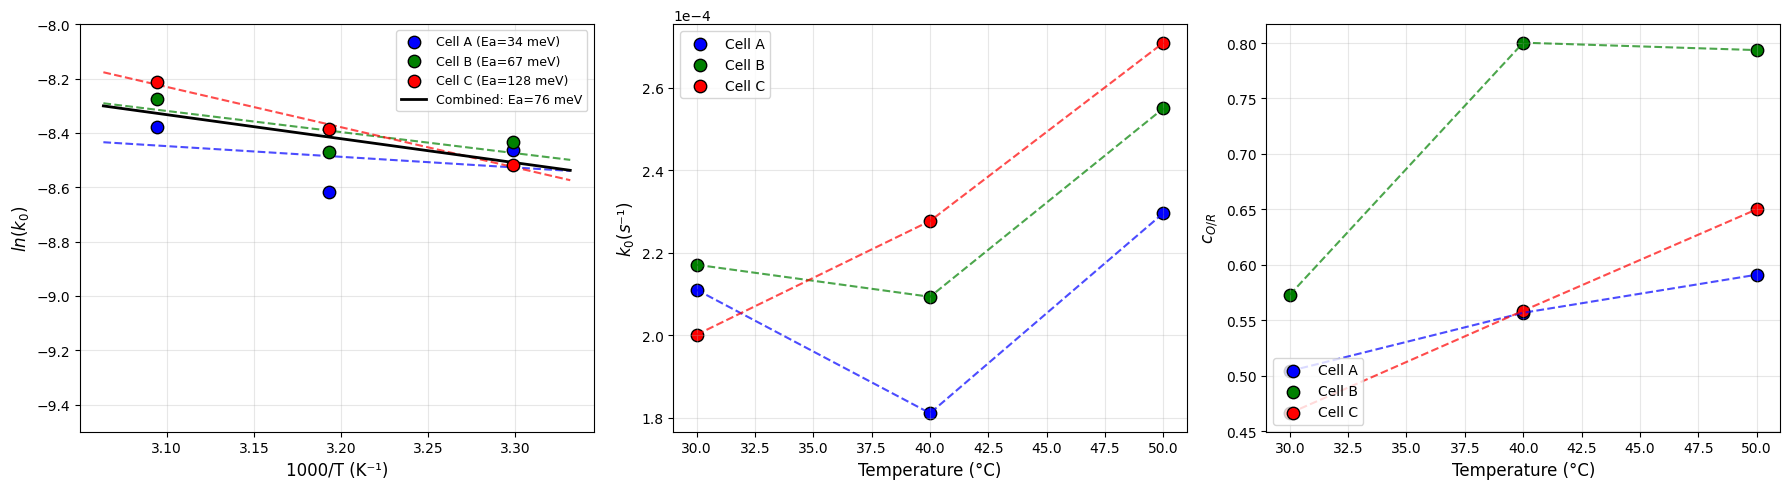

In [62]:
# Plot temperature trends
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cell_colors = {'A': 'blue', 'B': 'green', 'C': 'red'}
cell_letters = ['A', 'B', 'C']

# Conversion factor: 1 kJ/mol = 10.364 meV
kJ_to_meV = 10.364

# Plot 1: Arrhenius plot (ln(k01) vs 1/T) for each cell
ax1 = axes[0]
for cell in cell_letters:
    if cell in arrhenius_results:
        data = arrhenius_results[cell]
        Ea_meV = data["Ea_kJ"] * kJ_to_meV
        ax1.scatter(data['inv_T'] * 1000, data['ln_k01'], 
                   color=cell_colors[cell], s=80, zorder=5, 
                   edgecolors='black', linewidth=1, label=f'Cell {cell} (Ea={Ea_meV:.0f} meV)')
        
        # Fit line
        inv_T_fit = np.linspace(data['inv_T'].min() * 0.99, data['inv_T'].max() * 1.01, 100)
        ln_k01_fit = data['intercept'] + data['slope'] * inv_T_fit
        ax1.plot(inv_T_fit * 1000, ln_k01_fit, color=cell_colors[cell], 
                linestyle='--', linewidth=1.5, alpha=0.7)

# Add combined fit
all_inv_T_plot = np.array([1/fit_results[(c, t)]['T_kelvin'] for c in cell_letters for t in temperatures])
all_ln_k01_plot = np.array([np.log(fit_results[(c, t)]['k01']) for c in cell_letters for t in temperatures])
inv_T_fit_all = np.linspace(all_inv_T_plot.min() * 0.99, all_inv_T_plot.max() * 1.01, 100)
ln_k01_fit_all = intercept_all + slope_all * inv_T_fit_all
Ea_all_meV = Ea_all * kJ_to_meV
ax1.plot(inv_T_fit_all * 1000, ln_k01_fit_all, 'k-', linewidth=2,
        label=f'Combined: Ea={Ea_all_meV:.0f} meV')

ax1.set_xlabel('1000/T (K⁻¹)', fontsize=12)
ax1.set_ylabel(r'$ln(k_0)$', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(False, alpha=0.3)
ax1.set_ylim(-9.5,-8)

# Plot 2: k01 vs Temperature for each cell
ax2 = axes[1]
for cell in cell_letters:
    if cell in arrhenius_results:
        data = arrhenius_results[cell]
        T_celsius = data['T_kelvin'] - 273.15
        ax2.scatter(T_celsius, data['k01_values'], color=cell_colors[cell], 
                   s=80, edgecolors='black', linewidth=1, label=f'Cell {cell}')
        ax2.plot(T_celsius, data['k01_values'], color=cell_colors[cell], 
                linestyle='--', linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel(r'$k_0 (s⁻¹)$', fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
ax2.legend(fontsize=10)
ax2.grid(False, alpha=0.3)

# Plot 3: C vs Temperature for each cell
ax3 = axes[2]
for cell in cell_letters:
    if cell in arrhenius_results:
        data = arrhenius_results[cell]
        T_celsius = data['T_kelvin'] - 273.15
        if cell == "C" and T_celsius[2]==50:
            data['C_values'] = [0.46618136, 0.55859334, 0.65]
        print(T_celsius)
        print(data['C_values'])
        ax3.scatter(T_celsius, data['C_values'], color=cell_colors[cell], 
                   s=80, edgecolors='black', linewidth=1, label=f'Cell {cell}')
        ax3.plot(T_celsius, data['C_values'], color=cell_colors[cell], 
                linestyle='--', linewidth=1.5, alpha=0.7)

ax3.set_xlabel('Temperature (°C)', fontsize=12)
ax3.set_ylabel(r'$c_{O/R}$', fontsize=12)
ax3.legend(fontsize=10, loc='lower left')
ax3.grid(False, alpha=0.3)

plt.tight_layout()
plt.savefig('temperature_parameter_trends_individual.png', dpi=150, bbox_inches='tight')
plt.show()

In [55]:
# Analyze C parameter temperature dependence for each cell
print("Temperature Dependence of C (Individual Cells)")
print("=" * 70)

cell_letters = ['A', 'B', 'C']

for cell in cell_letters:
    if cell in arrhenius_results:
        data = arrhenius_results[cell]
        T_kelvin = data['T_kelvin']
        C_values = data['C_values']
        
        slope_C, intercept_C, r_value_C, _, _ = linregress(T_kelvin, C_values)
        
        print(f"\nCell {cell}:")
        print(f"  C values: {', '.join([f'{c:.4f}' for c in C_values])}")
        print(f"  Linear fit: C = {intercept_C:.4f} + ({slope_C:.6f}) × T")
        print(f"  R² = {r_value_C**2:.4f}")
        print(f"  dC/dT = {slope_C:.6f} K⁻¹")

# Overall summary
print("\n" + "=" * 70)
print("SUMMARY: C vs Temperature trends")
print("=" * 70)
for temp in temperatures:
    C_at_temp = [fit_results[(cell, temp)]['C'] for cell in cell_letters if (cell, temp) in fit_results]
    print(f"{temp}°C: C = {np.mean(C_at_temp):.4f} ± {np.std(C_at_temp):.4f}")

Temperature Dependence of C (Individual Cells)

Cell A:
  C values: 0.5042, 0.5567, 0.5911
  Linear fit: C = -0.8085 + (0.004340) × T
  R² = 0.9856
  dC/dT = 0.004340 K⁻¹

Cell B:
  C values: 0.5730, 0.8003, 0.7936
  Linear fit: C = -2.7323 + (0.011032) × T
  R² = 0.7273
  dC/dT = 0.011032 K⁻¹

Cell C:
  C values: 0.4662, 0.5586, 0.4737
  Linear fit: C = 0.3824 + (0.000374) × T
  R² = 0.0053
  dC/dT = 0.000374 K⁻¹

SUMMARY: C vs Temperature trends
30°C: C = 0.5145 ± 0.0442
40°C: C = 0.6385 ± 0.1144
50°C: C = 0.6194 ± 0.1321


## Summary and Conclusions

In [56]:
# Final summary
print("=" * 80)
print("TEMPERATURE ANALYSIS SUMMARY (Individual Cells)")
print("=" * 80)

print(f"\nFixed parameters:")
print(f"  λ (reorganization energy) = {LAMBDA_FIXED}")
print(f"  k02 = {K02_FIXED:.4e} s⁻¹")

print(f"\n" + "-" * 80)
print("FITTED PARAMETERS BY CELL AND TEMPERATURE:")
print("-" * 80)

cell_letters = ['A', 'B', 'C']

for cell in cell_letters:
    print(f"\nCell {cell}:")
    for temp in temperatures:
        key = (cell, temp)
        if key in fit_results:
            r = fit_results[key]
            print(f"  {temp}°C: k01 = {r['k01']:.6e} s⁻¹, C = {r['C']:.4f}, R² = {r['r2']:.4f}")

print(f"\n" + "-" * 80)
print("ARRHENIUS ANALYSIS (Activation Energy):")
print("-" * 80)
for cell in cell_letters:
    if cell in arrhenius_results:
        ar = arrhenius_results[cell]
        print(f"  Cell {cell}: Ea = {ar['Ea_kJ']:.2f} kJ/mol, A = {ar['A']:.4e} s⁻¹ (R² = {ar['r_squared']:.4f})")

print(f"  Combined: Ea = {Ea_all:.2f} kJ/mol, A = {A_all:.4e} s⁻¹ (R² = {r_value_all**2:.4f})")

print(f"\n" + "-" * 80)
print("AVERAGE PARAMETERS PER TEMPERATURE:")
print("-" * 80)
for temp in temperatures:
    k01_vals = [fit_results[(cell, temp)]['k01'] for cell in cell_letters if (cell, temp) in fit_results]
    C_vals = [fit_results[(cell, temp)]['C'] for cell in cell_letters if (cell, temp) in fit_results]
    r2_vals = [fit_results[(cell, temp)]['r2'] for cell in cell_letters if (cell, temp) in fit_results]
    print(f"  {temp}°C: k01 = {np.mean(k01_vals):.4e} ± {np.std(k01_vals):.4e}, "
          f"C = {np.mean(C_vals):.4f} ± {np.std(C_vals):.4f}, "
          f"R² = {np.mean(r2_vals):.4f}")

print(f"\n" + "=" * 80)

# Save results to CSV
results_df.to_csv('temperature_analysis_results_individual.csv', index=False)
print("\nResults saved to 'temperature_analysis_results_individual.csv'")

TEMPERATURE ANALYSIS SUMMARY (Individual Cells)

Fixed parameters:
  λ (reorganization energy) = 8.3
  k02 = 2.0930e-04 s⁻¹

--------------------------------------------------------------------------------
FITTED PARAMETERS BY CELL AND TEMPERATURE:
--------------------------------------------------------------------------------

Cell A:
  30°C: k01 = 2.110185e-04 s⁻¹, C = 0.5042, R² = 0.9508
  40°C: k01 = 1.810645e-04 s⁻¹, C = 0.5567, R² = 0.9670
  50°C: k01 = 2.296248e-04 s⁻¹, C = 0.5911, R² = 0.9221

Cell B:
  30°C: k01 = 2.170843e-04 s⁻¹, C = 0.5730, R² = 0.9606
  40°C: k01 = 2.093126e-04 s⁻¹, C = 0.8003, R² = 0.9630
  50°C: k01 = 2.550484e-04 s⁻¹, C = 0.7936, R² = 0.9528

Cell C:
  30°C: k01 = 2.001099e-04 s⁻¹, C = 0.4662, R² = 0.9553
  40°C: k01 = 2.277058e-04 s⁻¹, C = 0.5586, R² = 0.9203
  50°C: k01 = 2.709725e-04 s⁻¹, C = 0.4737, R² = 0.9449

--------------------------------------------------------------------------------
ARRHENIUS ANALYSIS (Activation Energy):
-----------------